# Desafío - Árboles de regresión
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Árboles de regresión.

## Requerimientos
- Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
- Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable `Sale_Price`.

### Ejercicio 1: Preparación del ambiente de trabajo
- Importe las librerías clásicas a utilizar.
- Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase `DecisionTreeRegressor`.
- De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
- Elimine la columna `Unnamed: 0` cuando cargue los datos.

In [1]:
# Utiliza esta celda para importar las librerías y el set de datos
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV

import pickle

import warnings
warnings.simplefilter('ignore')

df = pd.read_csv('Datasets/ames_housing.csv').drop(columns='Unnamed: 0')
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


### Ejercicio 2: Feature engineering
- Identifique si el `dtype` de cada `pd.Series` en nuestra base de datos se considera `object` o no. Para todas las variables que sean `object`, realice lo siguiente:
    - Genere una recodificación $k-1$ en cada variable.
    - Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar.
    - Pueden utilizar la función con la opción `drop_first` para ello.
- Utilizando el método `pd.concat`, concatene a los atributos creados en la base de datos.

_**Tip**_: No se olvide de eliminar los atributos recodificados, de esta forma evitará un aumento artificial del desempeño del modelo.

In [2]:
# Utiliza esta celda para generar el DataFrame solicitado

df_object = df.select_dtypes('object')
df_number = df.select_dtypes(np.number)

df_dummies = pd.get_dummies(df_object, drop_first=True)

df_dummies.shape, df_number.shape

df_work = pd.concat([df_number, df_dummies], axis=1)
df_work.head()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


### Ejercicio 3: Primer modelo
- Genere muestras de entrenamiento y validación con `Sale_Price` como vector objetivo y los atributos de la base de datos como matriz.
- Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
- Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento _sin modificar los hiper parámetros_.
- Reporte las principales métricas de desempeño
- Comente sobre el desempeño.

In [3]:
# Utiliza esta celda para generar los subsets de datos

X = df_work.drop(columns='Sale_Price')
y = df_work['Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 11238)

In [4]:
grilla = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {'max_features': np.linspace(1, X_train.shape[1]) , 
                        'max_depth': np.linspace(1, 32, num = 32, endpoint = True).astype(int)}, cv = 5, n_jobs = -1)

In [5]:
# Utiliza esta celda para entrenar el modelo solicitado
modelo = DecisionTreeRegressor()
modelo.fit(X_train, y_train)

DecisionTreeRegressor()

In [6]:
# Utiliza esta celda para reportar las métricas solicitadas

y_hat = modelo.predict(X_test)

print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_hat))}")
print(f"Median Absolute Error: {median_absolute_error(y_test, y_hat)}")
print(f"R2 Score: {r2_score(y_test, y_hat)}")

Root Mean Squared Error: 37637.77715410912
Median Absolute Error: 16900.0
R2 Score: 0.7507509828824119


**Comentarios**

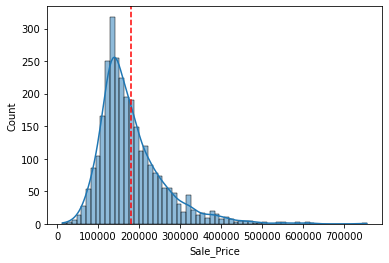

In [7]:
sns.histplot(df['Sale_Price'], kde=True)
plt.axvline(df['Sale_Price'].mean(), ls='--', color='red')

### Ejercicio 4: Importancia relativa
- Implemente la función `plot_importance` utilizado en la lectura para reportar la importancia relativa de los atributos.
- Comente sobre cuáles son los principales 10 atributos que afectan la predicción de `Sale_Price`.
- Separe estos 10 atributos en una nueva base de datos, junto con el vector objetivo.

In [8]:
#!pip install pydotplus

In [9]:
# Utiliza esta celda para definir la función solicitada
from lec7_graphs import plot_importance

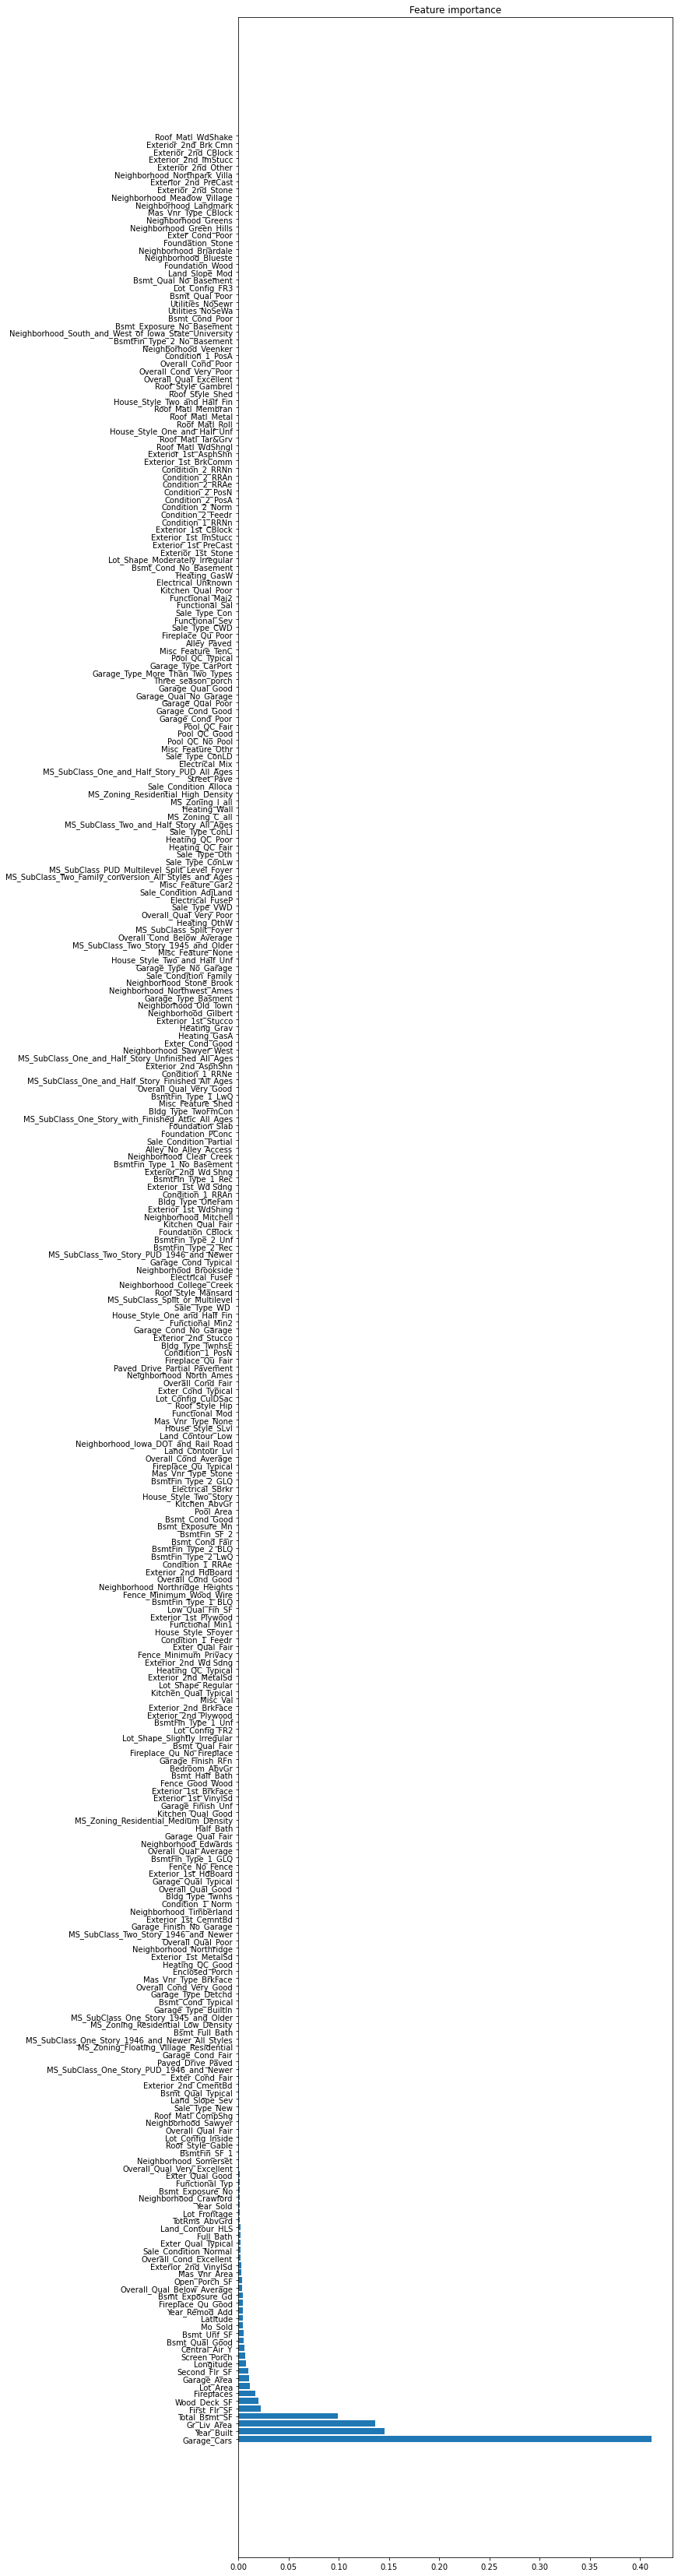

In [10]:
# Utiliza esta celda para realizar el llamado de la función
plt.figure(figsize=(10,60))
plot_importance(modelo, X_train.columns)

In [11]:
# Utiliza esta celda para generar el nuevo set solicitado
hold_importance = modelo.feature_importances_
sort_importance = np.argsort(hold_importance)[::-1]

names = [X_train.columns[i] for i in sort_importance][:10]

df_work_10 = df_work[names + ['Sale_Price']]

df_work_10.head()

,Garage_Cars,Year_Built,Gr_Liv_Area,Total_Bsmt_SF,First_Flr_SF,Wood_Deck_SF,Fireplaces,Lot_Area,Garage_Area,Second_Flr_SF,Sale_Price
0,2,1960,1656,1080,1656,210,2,31770,528,0,215000
1,1,1961,896,882,896,140,0,11622,730,0,105000
2,1,1958,1329,1329,1329,393,0,14267,312,0,172000
3,2,1968,2110,2110,2110,0,2,11160,522,0,244000
4,2,1997,1629,928,928,212,1,13830,482,701,189900


In [12]:
df_work_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Garage_Cars    2930 non-null   int64
 1   Year_Built     2930 non-null   int64
 2   Gr_Liv_Area    2930 non-null   int64
 3   Total_Bsmt_SF  2930 non-null   int64
 4   First_Flr_SF   2930 non-null   int64
 5   Wood_Deck_SF   2930 non-null   int64
 6   Fireplaces     2930 non-null   int64
 7   Lot_Area       2930 non-null   int64
 8   Garage_Area    2930 non-null   int64
 9   Second_Flr_SF  2930 non-null   int64
 10  Sale_Price     2930 non-null   int64
dtypes: int64(11)
memory usage: 251.9 KB


### Ejercicio 5: Refactorización del modelo y picklingpd.get_dummies
- En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
- Dentro de los datos de entrenamiento genere una búsqueda de grilla con `GridSearchCV` utilizando los siguientes hiper parámetros:
    - **Máximo de atributos**: Evalúe todos los posibles atributos.
    - **Máximo de profundidad**: Entre 1 a 32.
    - **Validaciones cruzadas**: 5.
- Reporte la mejor combinación de hiper parámetros y su desempeño asociado.
- Compare el desempeño en la muestra de validación con el modelo por defecto.

In [13]:
# Utiliza esta celda para generar los nuevos sets de datos

X = df_work_10.drop(columns='Sale_Price')
y = df_work_10['Sale_Price']

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, y, test_size = .33, random_state = 11238)

In [14]:
# Utiliza esta celda para generar y entrenar el objeto GridSearchCV

grilla = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {'max_features': np.linspace(1, X_train_g.shape[1]) , 
                        'max_depth': np.linspace(1, 32, num = 32, endpoint = True).astype(int)}, cv = 5, n_jobs = -1)

In [15]:
# Utiliza esta celda para mostrar mejores hiperparámetros y puntaje asociado

grilla.fit(X_train_g, y_train_g)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
                         'max_features': array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3...
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ])})

In [16]:
# Utiliza esta celda para mostrar las métricas de desempeño

grilla.best_score_

0.7376785381853763

In [17]:
mejor_modelo = grilla.best_estimator_

In [18]:
y_hat_g = grilla.best_estimator_.predict(X_test_g)

print(f'''Metricas
MSE: {np.sqrt(mean_squared_error(y_test_g, y_hat))}
MAE: {median_absolute_error(y_test_g, y_hat)}
R2 Score: {r2_score(y_test_g, y_hat)}''')

Metricas
MSE: 37637.77715410912
MAE: 16900.0
R2 Score: 0.7507509828824119


**Comentarios**

### Pickling
- Ahora generamos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo `pickle`.
- `pickle` contiene la función `dump`, que permite guardar el modelo desarrollado. 
- La forma canónica para desarrollar el pickling es:
```python
pickle.dump(<OBJETO_CON_EL_MODELO>,open('nombre-apellido-actividad07.sav', 'wb'))
```
- Envíe su modelo y conjuntos de entrenamiento a un compañero.

In [19]:
pickle.dump(mejor_modelo,open('archivos/model_dms_ct.sav', 'wb'))

### Serialización de datos
- Los `pd.DataFrame` se pueden guardar como archivos csv con el método `.to_csv('nombre_archivo.csv', index=False)`
- El parámetro `index=False` evita que se genere la columna `Unnamed: 0`

In [20]:
# Utiliza esta celda para guardar archivos csv de las muestras generadas con train test split para el último modelo
X_train_g.to_csv('archivos/X_train.csv', index = False)
X_test_g.to_csv('archivos/X_test.csv', index = False)
y_train_g.to_csv('archivos/y_train.csv', index = False)
y_test_g.to_csv('archivos/y_test.csv', index = False)

In [21]:
X_train.head()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
1623,63,7875,1996,1996,0,6,0,277,691,691,...,0,0,0,0,1,0,0,0,1,0
1297,60,6756,1910,1950,0,7,0,481,481,899,...,0,0,0,0,1,0,0,0,1,0
1310,34,4571,1916,1950,0,7,0,624,624,624,...,0,0,0,0,0,0,0,0,0,0
1152,65,8450,1968,1968,0,1,0,0,890,890,...,0,0,0,0,1,0,0,0,1,0
293,78,10452,1941,1985,371,1,252,850,1528,1225,...,0,0,0,0,1,0,0,0,1,0


In [22]:
pd_out_X_test = pd.read_csv('archivos/X_test.csv')
pd_out_X_train = pd.read_csv('archivos/X_train.csv')
pd_out_y_test = pd.read_csv('archivos/y_test.csv')
pd_out_y_train = pd.read_csv('archivos/y_train.csv')

In [23]:
pd_out_X_test.sample(6, random_state = 15820)

,Garage_Cars,Year_Built,Gr_Liv_Area,Total_Bsmt_SF,First_Flr_SF,Wood_Deck_SF,Fireplaces,Lot_Area,Garage_Area,Second_Flr_SF
652,1,1938,954,920,954,0,1,6305,240,0
646,2,2002,1409,1409,1409,0,1,12864,576,0
48,2,1948,1495,864,1064,180,0,8064,576,0
406,1,1963,1146,1083,1146,345,1,10184,294,0
785,1,1920,1550,817,940,0,1,21780,318,610
520,2,1992,996,936,996,120,0,9069,564,0


In [24]:
pd_out_X_train.sample(6, random_state = 15820)

,Garage_Cars,Year_Built,Gr_Liv_Area,Total_Bsmt_SF,First_Flr_SF,Wood_Deck_SF,Fireplaces,Lot_Area,Garage_Area,Second_Flr_SF
394,1,1925,1015,768,1015,0,0,6120,450,0
73,1,1920,1344,672,672,0,0,10690,468,672
105,3,2006,1939,1095,1095,192,1,10728,1053,844
632,2,2005,1306,1306,1306,170,1,5381,624,0
1666,1,1972,864,864,864,0,0,7180,352,0
807,2,1974,1877,1084,1084,0,1,8000,488,793


In [25]:
X = df_work_10.drop(columns = 'Sale_Price')
y = df_work_10['Sale_Price']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size = .33, random_state = 11238)

In [26]:
get_model_params = GridSearchCV(DecisionTreeRegressor(),
                                {'max_features': list(range(1, X_train_p.shape[1])),
                                'max_depth': np.linspace(1, 32, num = 32, endpoint = True).astype(int)},
                                cv = 5, n_jobs = -1).fit(X_train_p, y_train_p)

In [27]:
get_model_params.best_estimator_

DecisionTreeRegressor(max_depth=7, max_features=6)

In [28]:
# Modelo y datos de entrenamiento y validacion a usar en desafio evaluado
pickle.dump(get_model_params.best_estimator_, open('archivos/model_dms.sav', 'wb'))
pickle.dump(X_train_p, open('archivos/X_train.sav', 'wb'))
pickle.dump(X_test_p, open('archivos/X_test.sav', 'wb'))
pickle.dump(y_train_p, open('archivos/y_train.sav', 'wb'))
pickle.dump(y_test_p, open('archivos/y_test.sav', 'wb'))